In [6]:
import yaml
import h5py
import numpy as np
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import nibabel as nib
import pandas as pd
from IPython.display import clear_output
from skimage.segmentation import find_boundaries
import napari
from skimage import exposure, io, measure
from skimage import color, io
from skimage import morphology
from skimage import measure
from skimage.measure import regionprops, regionprops_table

In [7]:
gasp = "/Users/dvarelat/Documents/MASTER/TFM/DATA/RESULTS/membranes/GASP_PNAS/20190404_E1_mGFP_CardiacRegion_0.5_XYZ_predictions_GASP.nii.gz"
decon05_cc = "/Users/dvarelat/Documents/MASTER/TFM/DATA/CardiacRegion/20190404_E1/20190404_E1_mGFP_CardiacRegion_0.5.nii.gz"

In [4]:
gasp_pred = nib.load(gasp).get_fdata()
gasp_pred.shape

(877, 829, 526)

In [8]:
mem_decon = nib.load(decon05_cc).get_fdata()
mem_decon = mem_decon[:,:,:,0]
mem_decon.shape

(877, 829, 526)

In [11]:
img = morphology.label(gasp_pred)

In [13]:
cell_vol = np.unique(img, return_counts=True)[1][1:]

In [14]:
len(np.unique(gasp_pred))

11571

In [21]:
boundaries = find_boundaries(gasp_pred)

In [26]:
boundaries.astype("uint16").shape

(877, 829, 526)

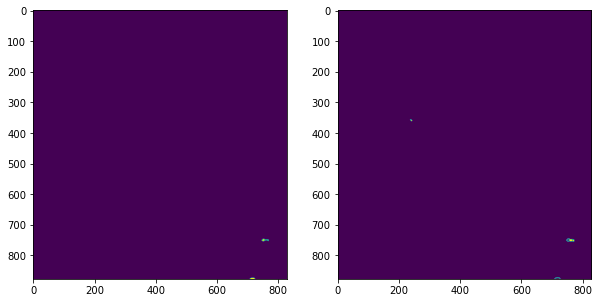

In [30]:
for t in range(52):
    plt.figure(figsize=(10,10)) 
    n = 10*t
    plots = [img[:, :, n], boundaries.astype("uint16")[:, :, n]]
    for i in range(len(plots)):
        plt.subplot(1,len(plots), i+1)
        plt.imshow(plots[i])
    plt.show()
    clear_output(wait=True)

In [32]:
def pixelcount(regionmask):
    return np.sum(regionmask)

## Extract properties

In [33]:
props = regionprops(img, extra_properties=(pixelcount,))

In [35]:
props[0].pixelcount

5857

In [38]:
cell_vol[0]

5857

## VISUALIZATION

In [128]:
viewer = napari.view_image(np.swapaxes(np.swapaxes(mem_decon, 0, 2), 1, 2), name='orignal')

In [129]:
viewer.add_labels(np.swapaxes(np.swapaxes(gasp_pred, 0, 2), 1, 2).astype("uint16"), name='labeled')

<Labels layer 'labeled' at 0x1cd53a4a0>

In [57]:
viewer.layers

[<Image layer 'orignal' at 0x1ae88bd60>, <Labels layer 'labeled' at 0x1be284d00>]

In [62]:
volume = (gasp_pred.astype("uint16") == props[3].label).transpose(1, 2, 0)

In [64]:
verts, faces, _, values = measure.marching_cubes(volume, level=0, spacing=(1.0, 1.0, 1.0))


In [65]:
surface_area_pixels = measure.mesh_surface_area(verts, faces)
print("Surface area (total pixels): {:0.2f}".format(surface_area_pixels))

Surface area (total pixels): 78.77


In [67]:
viewer.add_surface((verts[:, [2, 0, 1]], faces, np.random.random(len(verts))), name='surface')

<Surface layer 'surface [1]' at 0x1bd590df0>

### VOLUMEN EN SUPERFICIE

In [39]:
pixelcounts = [p.pixelcount for p in props]
len(pixelcounts)

11570

In [118]:
np.max(pixelcounts)

102001

In [105]:
order_index = sorted(range(len(pixelcounts)),key=pixelcounts.__getitem__)

In [119]:
pixelcounts[6673]

102001

### Inspect one cell

In [73]:
label = 3350
test_array = img.copy()
test_array_one = np.where(test_array == label, 1, 0)

In [74]:
test_array_one.shape

(877, 829, 526)

In [58]:
np.unique(test_array_one)

array([0, 1])

In [88]:
props[3349].centroid

(269.7841163310962, 559.2919463087248, 399.49888143176736)

In [83]:
#pd.DataFrame(test_array_one[260:280, 560:570, 399])

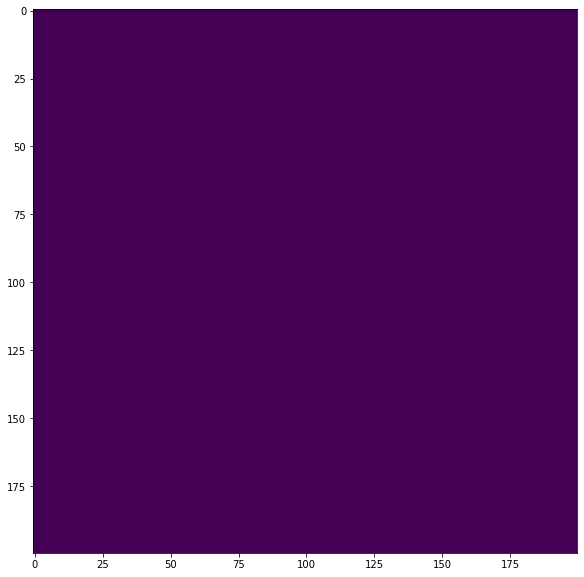

In [82]:
for t in range(52):
    plt.figure(figsize=(10,10)) 
    n = 10*t
    plots = [test_array_one[200:400, 400:600, n]]
    for i in range(len(plots)):
        plt.subplot(1,len(plots), i+1)
        plt.imshow(plots[i])
    plt.show()
    clear_output(wait=True)

In [89]:
#[p.centroid for p in props[:100]]


## Color in order

In [90]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

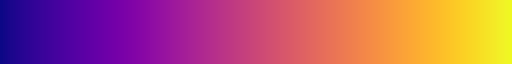

In [137]:
viridis = cm.get_cmap('plasma', len(pixelcounts))
viridis

In [127]:
len(pixelcounts)

11570

In [191]:
colores = viridis.colors

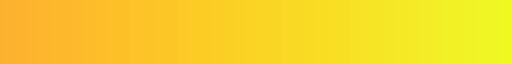

In [192]:
ListedColormap(colores[len(colores)-2000:])

In [ ]:
[colors_ordered[i] for i in bigger]

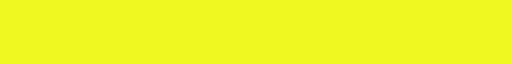

In [249]:
bigger_CELLS = order_index[len(order_index)-1000:]


In [247]:
dict_indices = dict(zip(order_index, range(len(order_index))))
dict_indices[6673]

11569

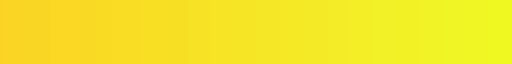

In [250]:
ListedColormap([colores[dict_indices[i]] for i in bigger_CELLS])

In [219]:
smaller_CELLS = order_index[:10]
smaller_CELLS

[1078, 1187, 11102, 3038, 3753, 8166, 1904, 1971, 2114, 7060]

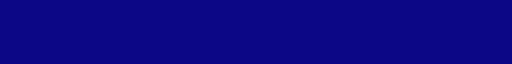

In [220]:
ListedColormap([colores[dict_indices[i]] for i in smaller_CELLS])

In [269]:
labels_ordered = [i+1 for i in order_index]

In [222]:
colors_ordered_ind = [dict_indices[i] for i in order_index]

In [223]:
colors_ordered = colores[colors_ordered_ind]
colors_ordered = list(map(tuple, colors_ordered))

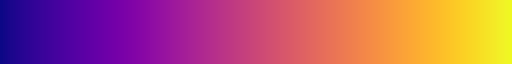

In [224]:
ListedColormap(colors_ordered)

In [228]:
labels_colors_order = [dict_indices[i] for i in range(len(props))]
labels_colors_order = colores[labels_colors_order]
labels_colors_order = list(map(tuple, labels_colors_order))

In [273]:
labels_colors_order[:10]

[(0.994495, 0.74088, 0.166335, 1.0),
 (0.76809, 0.244817, 0.498465, 1.0),
 (0.660374, 0.134144, 0.588971, 1.0),
 (0.959276, 0.921407, 0.151566, 1.0),
 (0.605485, 0.085854, 0.622686, 1.0),
 (0.944844, 0.507658, 0.302433, 1.0),
 (0.994474, 0.722691, 0.174381, 1.0),
 (0.826588, 0.315714, 0.441316, 1.0),
 (0.447714, 0.00208, 0.66024, 1.0),
 (0.274191, 0.012109, 0.622722, 1.0)]

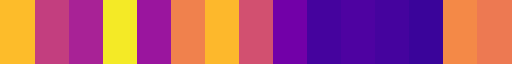

In [278]:
ListedColormap(labels_colors_order[:15])

In [277]:
## tamaños
pixelcounts[0:15]

[5857,
 3112,
 2750,
 12027,
 2604,
 4174,
 5636,
 3372,
 2119,
 1274,
 1505,
 1277,
 855,
 4339,
 4047]

### inspect some cells

In [252]:
labels = [i+1 for i in bigger_CELLS]
test_array = img.copy()

In [253]:
mask = np.isin(test_array, labels)
mask = mask.astype("uint16")

In [255]:
bound = find_boundaries(mask).astype("uint16")

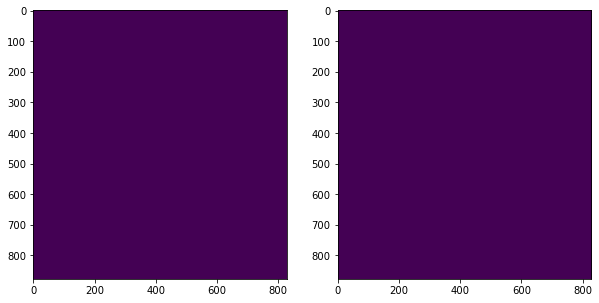

In [256]:
for t in range(52):
    plt.figure(figsize=(10,10)) 
    n = 10*t
    plots = [mask[:,:, n], bound[:,:,n]]
    for i in range(len(plots)):
        plt.subplot(1,len(plots), i+1)
        plt.imshow(plots[i])
    plt.show()
    clear_output(wait=True)

In [259]:
rgb_image = color.label2rgb(img, colors=labels_colors_order)

In [261]:
rgb_image.shape

(877, 829, 526, 3)

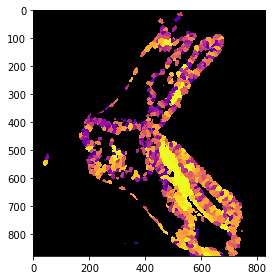

In [262]:
io.imshow(rgb_image[:,:, 200,:])

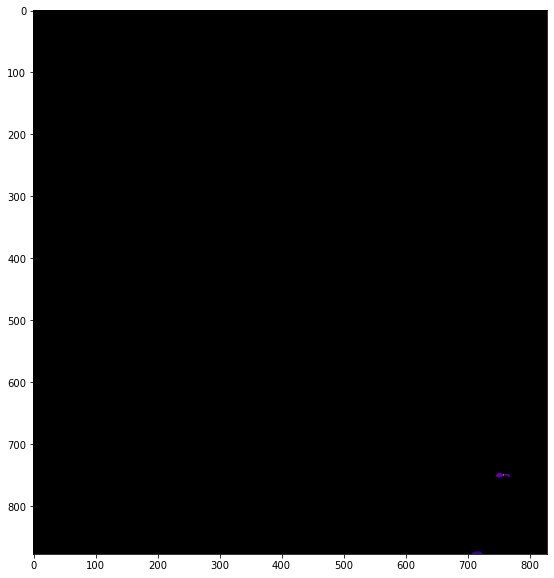

In [276]:
for t in range(52):
    plt.figure(figsize=(10,10)) 
    n = 10*t
    plots = [rgb_image[:,:, n,:]]
    for i in range(len(plots)):
        plt.subplot(1,len(plots), i+1)
        plt.imshow(plots[i])
    plt.show()
    clear_output(wait=True)

In [ ]:
#viewer.add_image(np.swapaxes(np.swapaxes(rgb_image, 0, 2), 1, 2) , name='ordered')

In [284]:
pixelcounts[0]

5857